In [68]:
import torch
from torch import nn
import pandas as pd
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
from torchinfo import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [57]:
class CustomImageDataset(Dataset):
    def __init__(self,img_dir,csv_file=None,label_col=None,transform=None):
        self.img_dir = img_dir
        self.images = os.listdir(img_dir)
        self.csv_file = csv_file
        if self.csv_file:
            self.annotations = pd.read_csv(csv_file)
            self.label_encoder = LabelEncoder()
            self.annotations[label_col] = self.label_encoder.fit_transform(self.annotations[label_col])
        self.transform = transform
    def __len__(self):
        return len(self.annotations) if self.csv_file else len(self.images)
    def __getitem__(self,idx):
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx,0] + ".jpg")
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.csv_file:
            label = int(self.annotations.iloc[idx,1])
            return image,label
        else:
            return image
    def classes(self):
        return self.label_encoder.classes_

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [59]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
pretrained_vit_transforms = pretrained_vit_weights.transforms()

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

summary(model=pretrained_vit,
    input_size=(32, 3, 224, 224),
    # col_names=["input_size"],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  False
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 19

In [60]:
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(dataset.classes())).to(device)

summary(model=pretrained_vit,
    input_size=(32, 3, 224, 224),
    # col_names=["input_size"],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 120]            768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [61]:
transform = transforms.Compose([
    pretrained_vit_transforms
])

dataset = CustomImageDataset(
    img_dir = "../../Data/Dog Breed dataset/train",
    csv_file = "../../Data/Dog Breed dataset/labels.csv",
    label_col = "breed",
    transform = transform
)
len(dataset)

10222

In [62]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(0.1*dataset_size)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_dataloader = DataLoader(dataset,batch_size=32,sampler=train_sampler)
val_dataloader = DataLoader(dataset,batch_size=32,sampler=val_sampler)

print(len(train_dataloader), len(val_dataloader))

288 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..1.2979523].
Clip

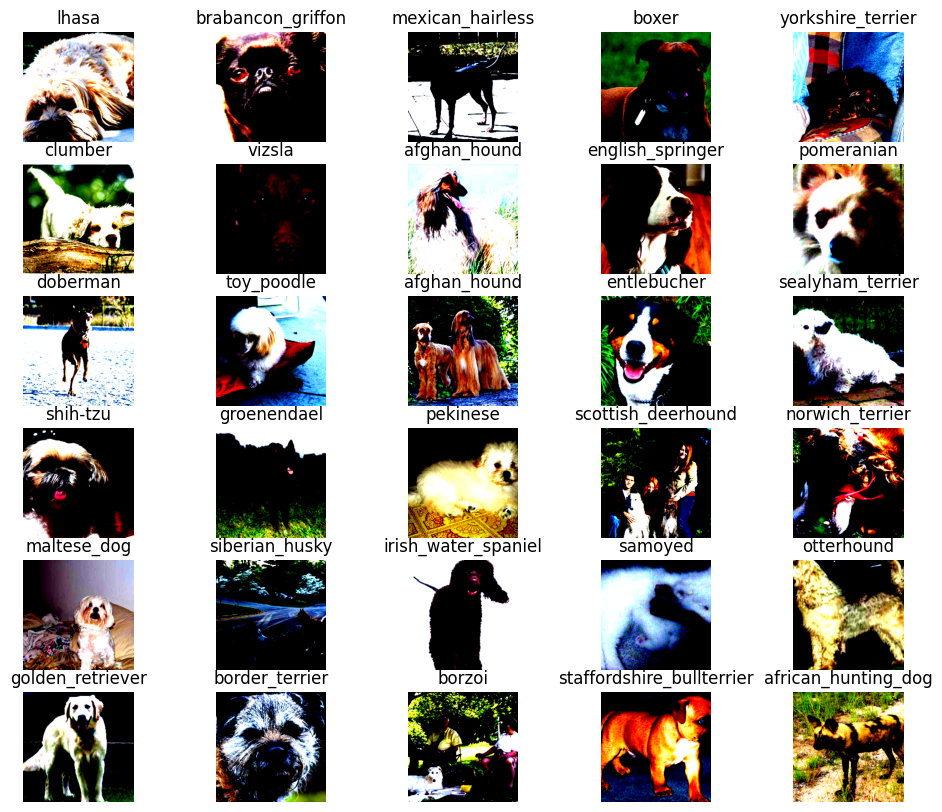

In [63]:
(img, label) = next(iter(train_dataloader))
fig, ax = plt.subplots(6,5,figsize=(12,10))
# ax[0][0].imshow(img[0].permute(1,2,0))
# ax[0][0].set_title(dataset.classes()[label[0]])
k=0
for i in range(6):
    for j in range(5):
        ax[i][j].imshow(img[k].permute(1,2,0))
        ax[i][j].axis(False)
        ax[i][j].set_title(dataset.classes()[label[k]])
        k+=1

In [64]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

In [67]:
EPOCHS=5
pretrained_vit.to(device)
for epoch in range(EPOCHS):
    train_loss = 0
    train_acc = 0
    pretrained_vit.train()
    for X,y in train_dataloader:
        X,y = X.to(device),y.to(device)
        y_logits = pretrained_vit(X)
        loss = loss_fn(y_logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        y_preds = torch.argmax(y_logits, dim=1)
        acc = ((y_preds==y).sum().item())/len(y_preds)
        train_acc += acc
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    test_loss = 0
    test_acc = 0
    pretrained_vit.eval()
    with torch.inference_mode():
        for X,y in val_dataloader:
            X,y = X.to(device),y.to(device)
            y_logits = pretrained_vit(X)
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()
            y_preds = torch.argmax(y_logits, dim=1)
            acc = ((y_preds==y).sum().item())/len(y_preds)
            test_acc += acc
        test_loss /= len(val_dataloader)
        test_acc /= len(val_dataloader)
        print(f"Epoch {epoch+1}/{EPOCHS} | train loss: {train_loss:.4f}, train acc: {train_acc:.2f} | test loss: {test_loss:.4f}, test acc: {test_acc:.2f}")

Epoch 1/5 | train loss: 0.0980, train acc: 0.97 | test loss: 0.2057, test acc: 0.94
Epoch 2/5 | train loss: 0.0715, train acc: 0.98 | test loss: 0.1911, test acc: 0.94
Epoch 3/5 | train loss: 0.0550, train acc: 0.98 | test loss: 0.1918, test acc: 0.95
Epoch 4/5 | train loss: 0.0431, train acc: 0.99 | test loss: 0.2032, test acc: 0.95
Epoch 5/5 | train loss: 0.0356, train acc: 0.99 | test loss: 0.2079, test acc: 0.94


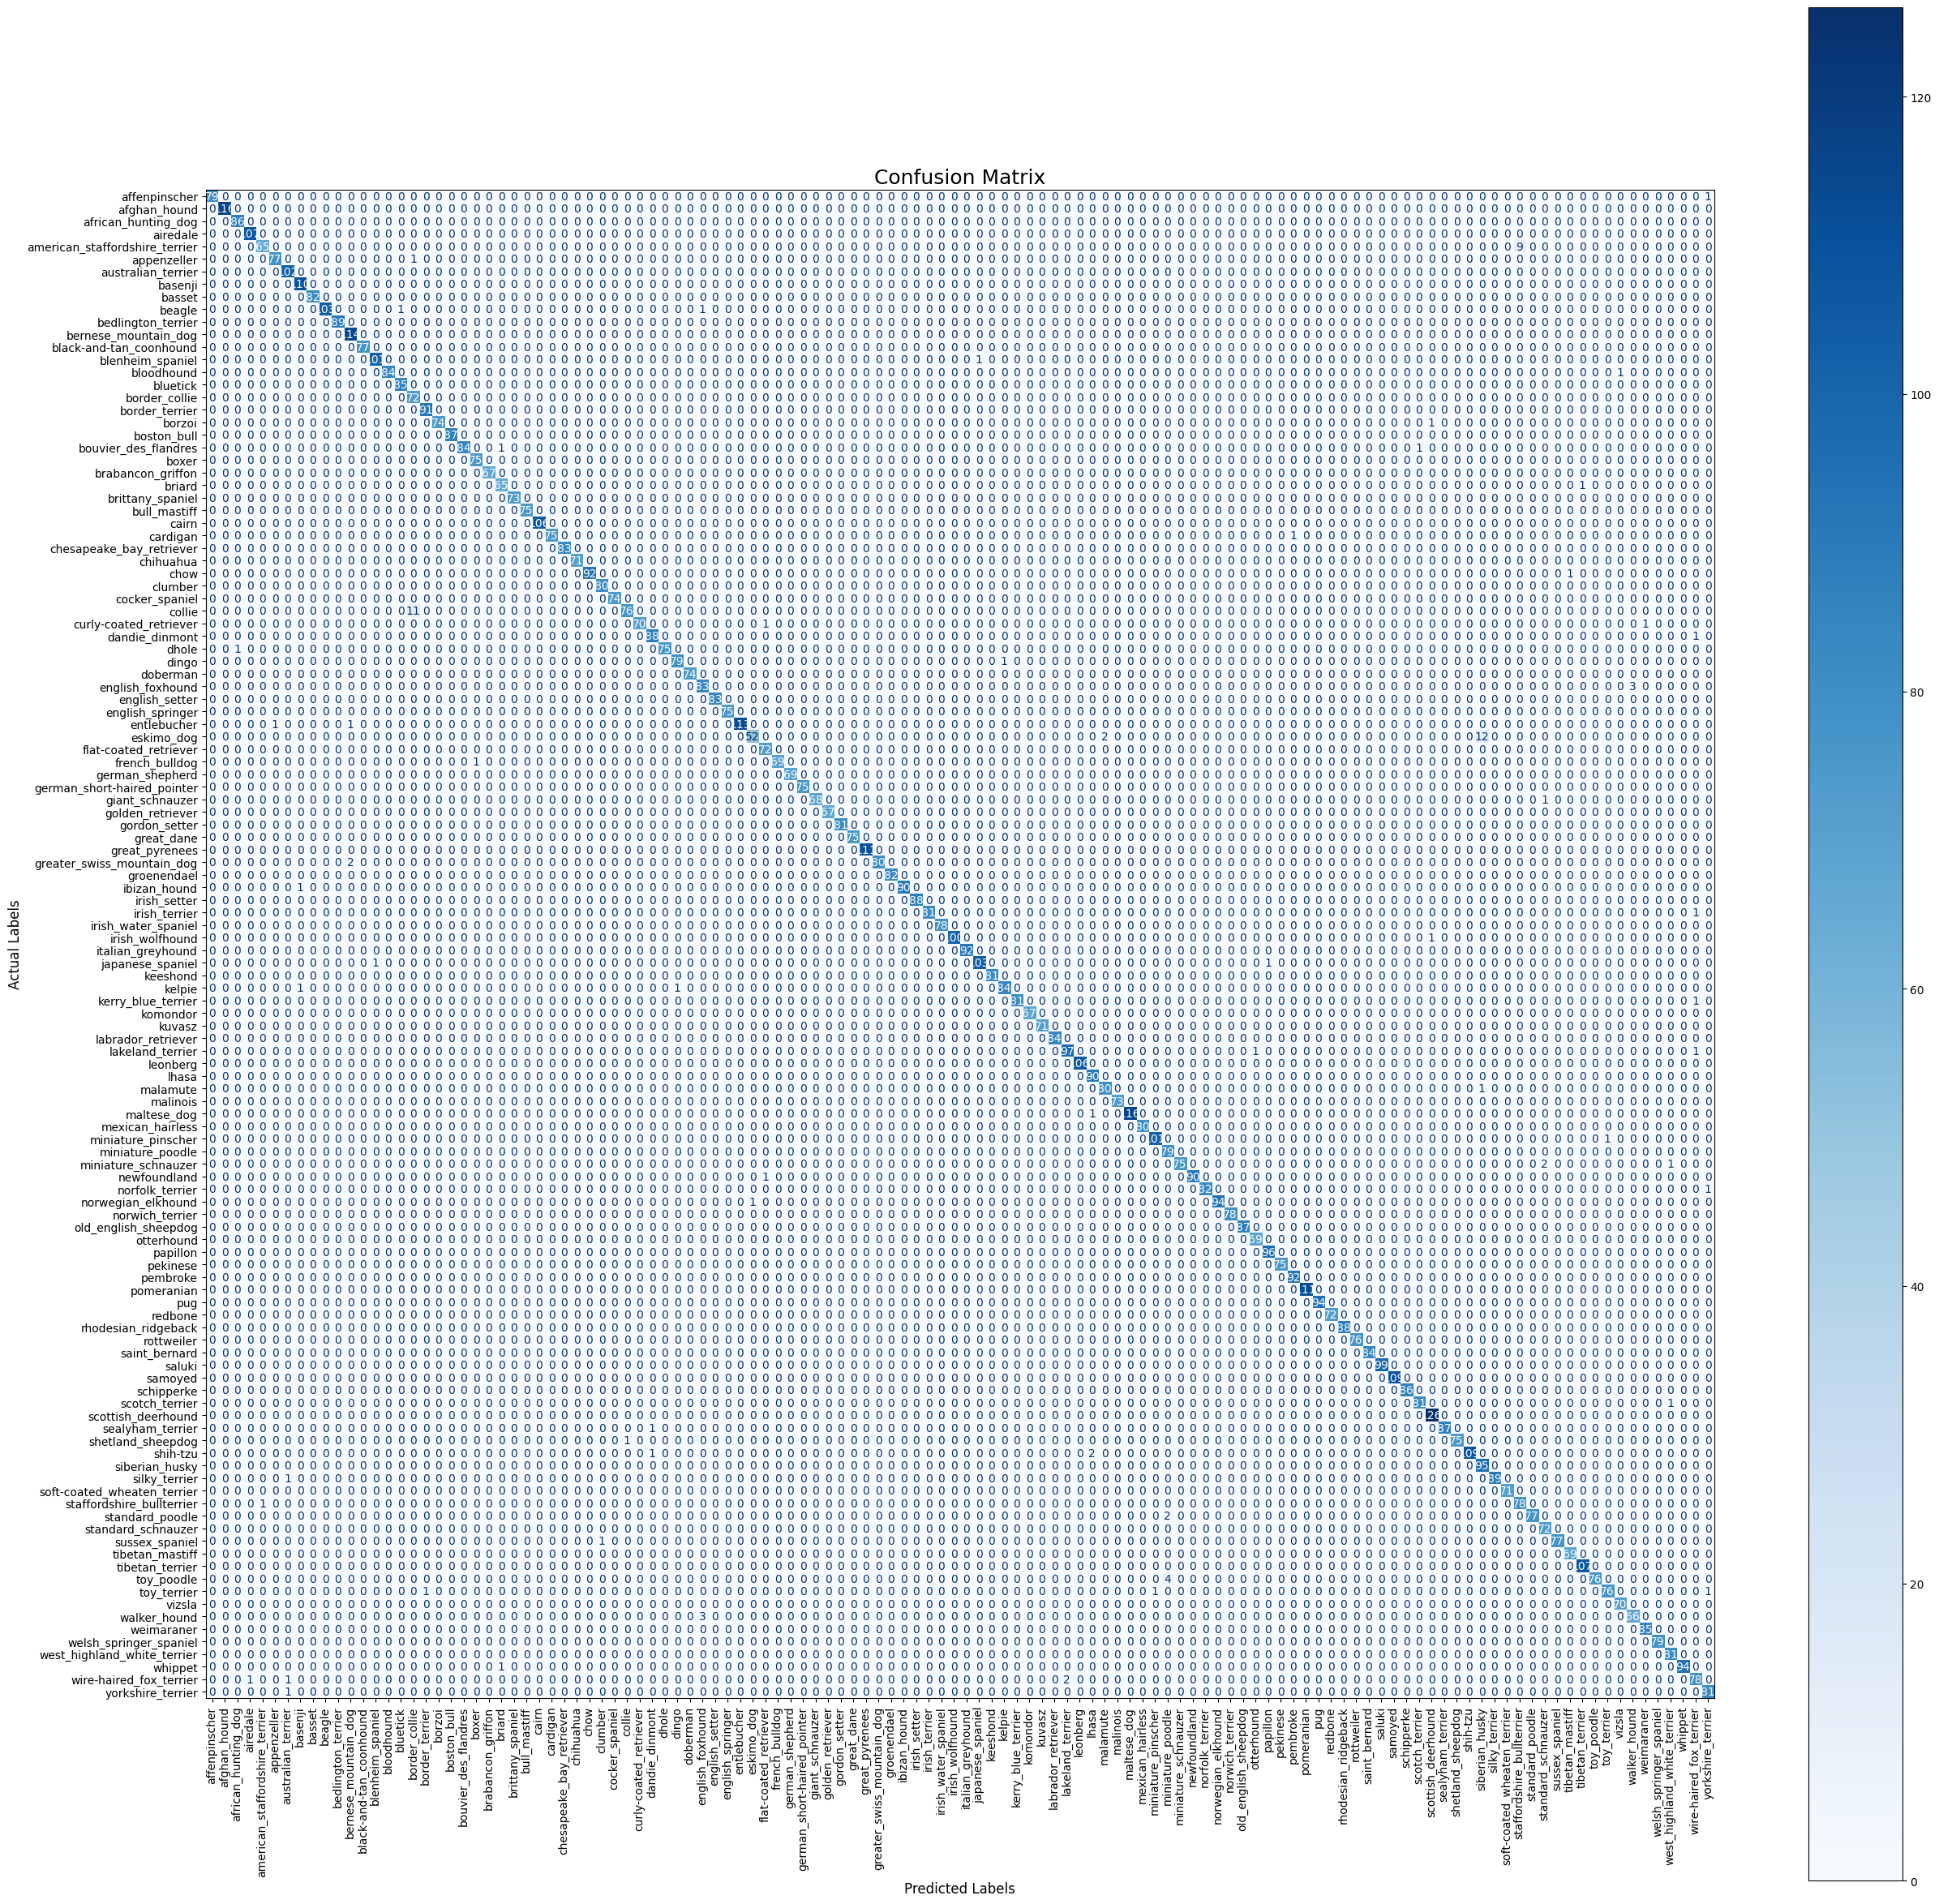

In [79]:
y_true = []
predictions = []
for data in dataset:
    y_true.append(data[1])
    pred = pretrained_vit(data[0].unsqueeze(0).to(device))
    index = torch.argmax(pred,dim=1).to("cpu")
    predictions.append(index.item())
    
cm = confusion_matrix(y_true, predictions)
fig, ax = plt.subplots(figsize=(30,30))
disp = ConfusionMatrixDisplay(cm,display_labels=dataset.classes())
disp.plot(cmap="Blues", ax=ax)
ax.set_xticklabels(dataset.classes(),rotation=90)
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel("Predicted Labels", fontsize=12)
ax.set_ylabel("Actual Labels", fontsize=12)
ax.tick_params(axis='both', labelsize=10)

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

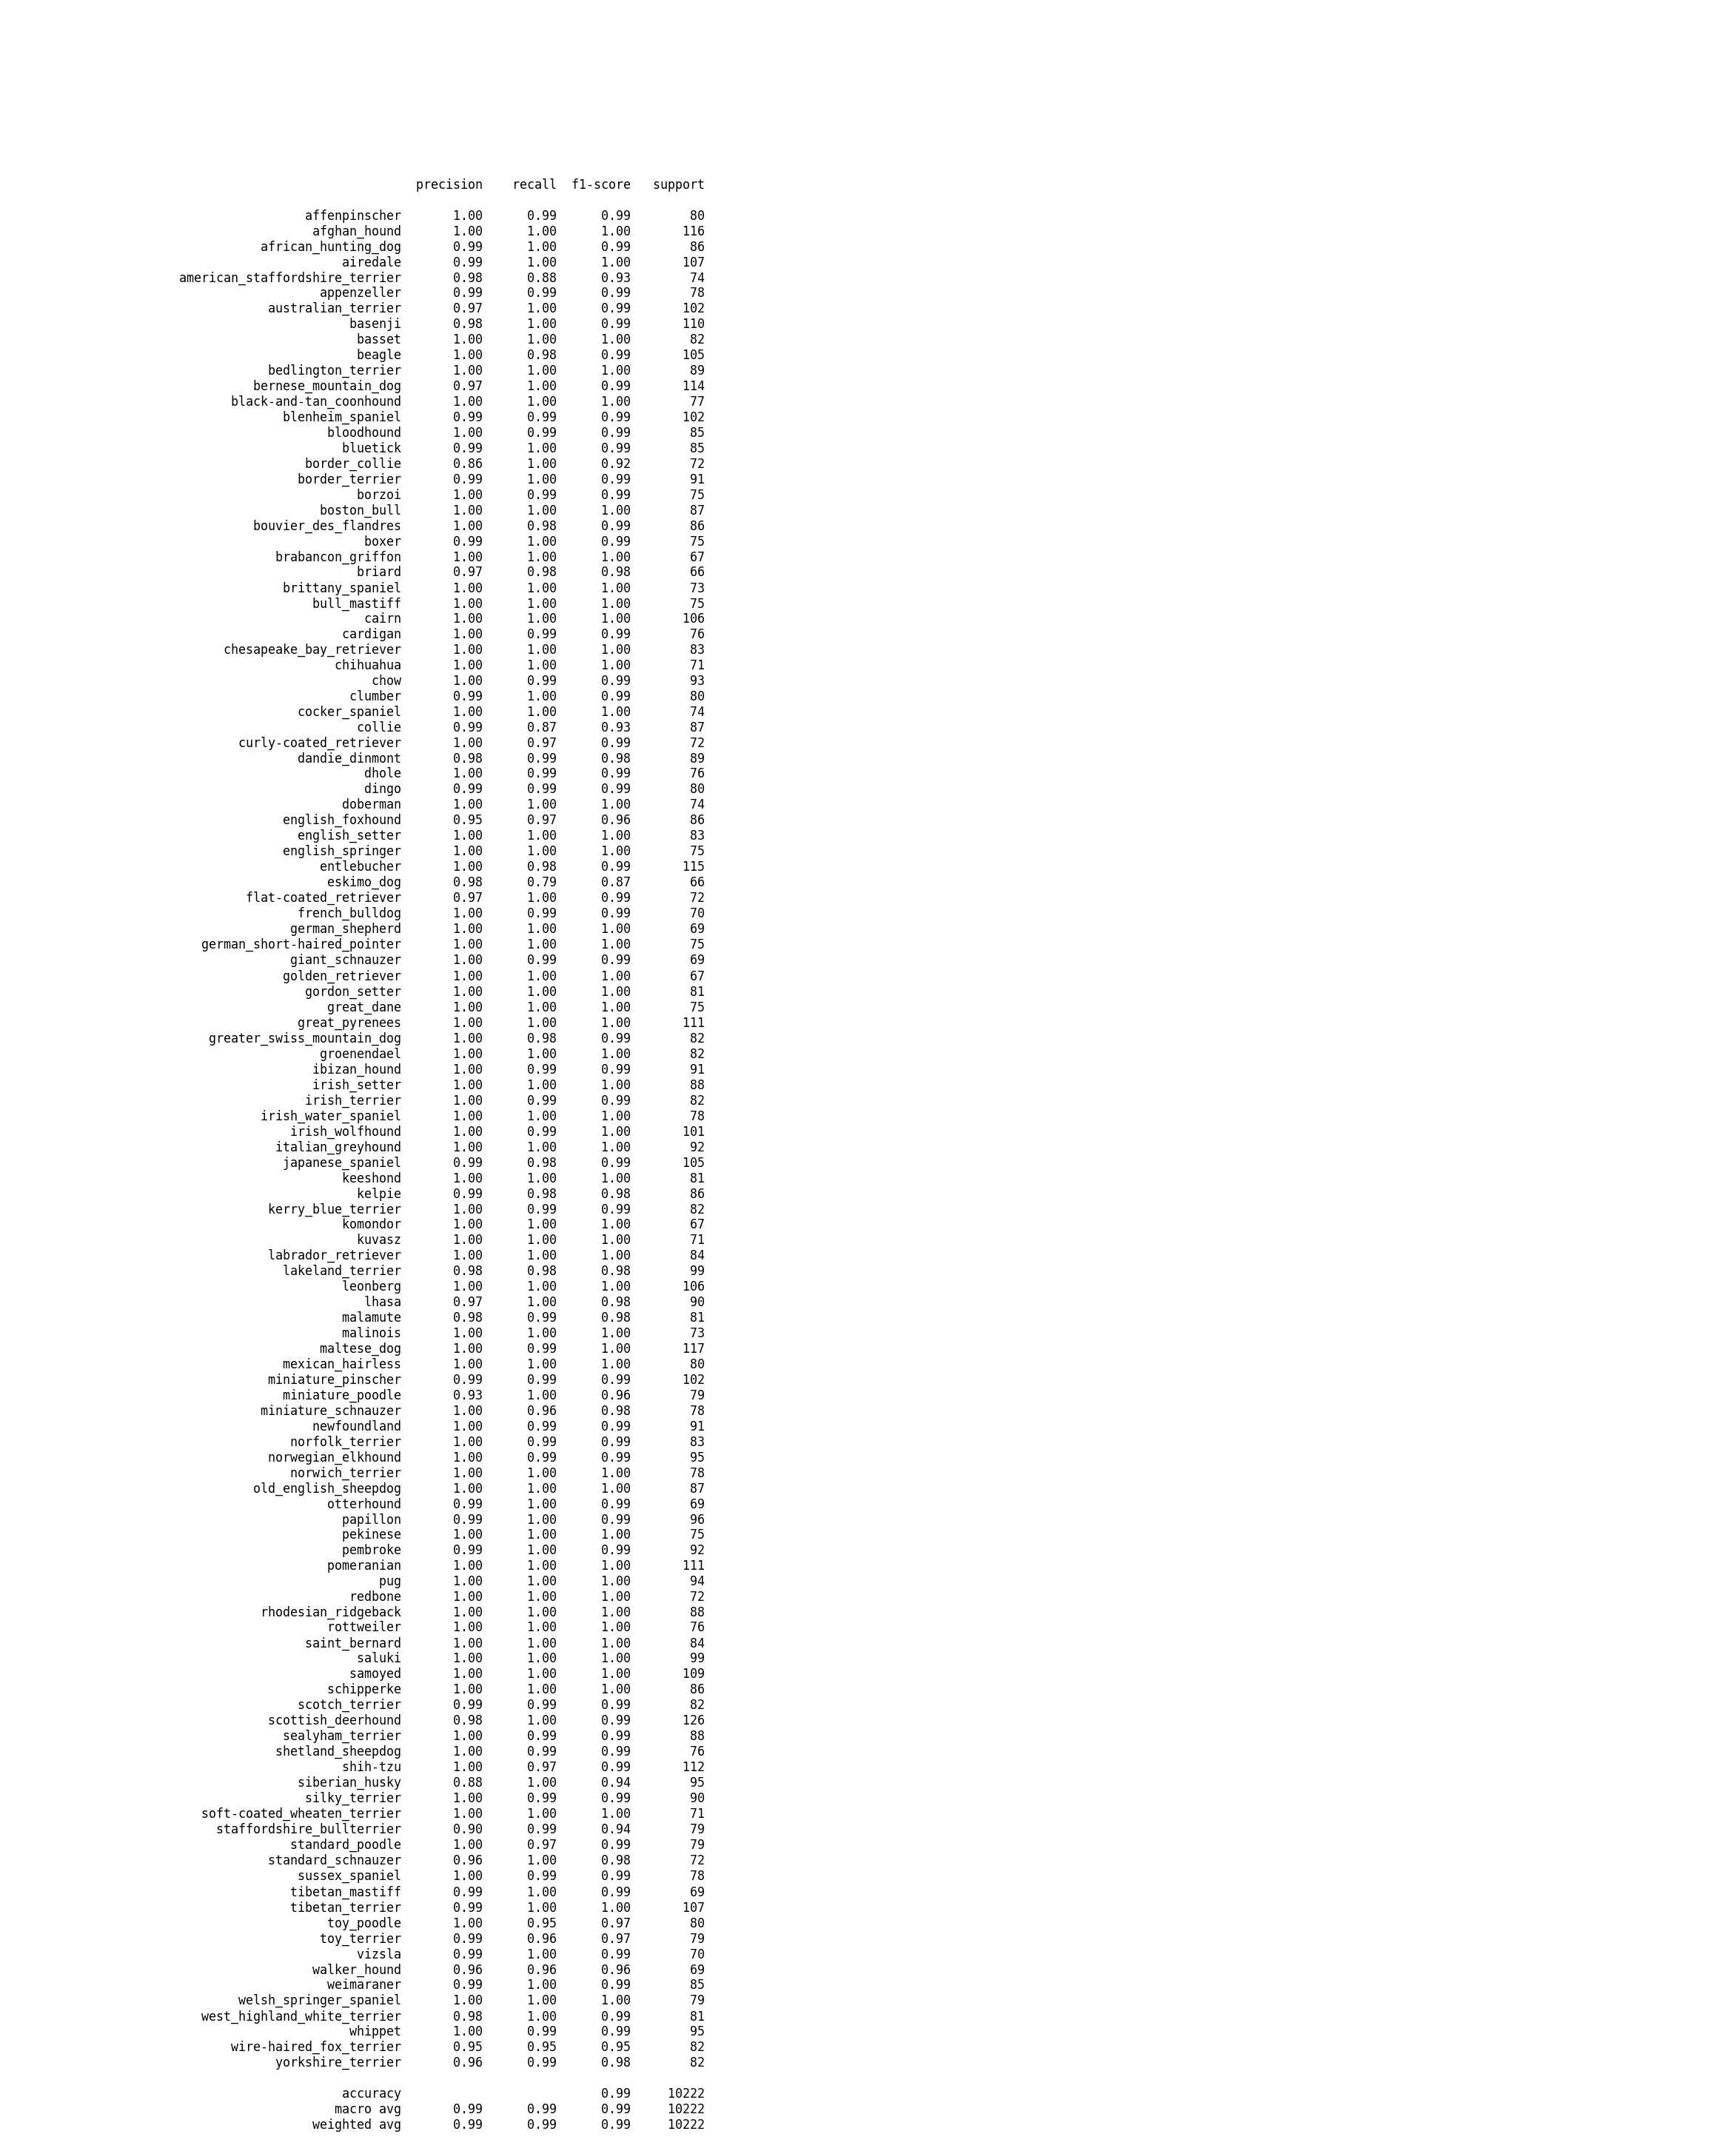

In [94]:
report = classification_report(y_true, predictions, target_names=dataset.classes())
fig, ax = plt.subplots(figsize=(30, 30))
ax.text(0.1, 0.9, report, fontsize=12, family='monospace', verticalalignment='top')
ax.axis('off')